In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "CO-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn033491,MGMGEGGGGGGKCYPAGWGIAAKPCDLCKSAVALLFCRVDSAFLCM...,361,1
1,Achn062021,MGYLCDFCGEQRSMVYCRSDAACLCLSCDRNVHSANALSRRHSRTL...,407,1
2,Achn063291,MEPLCEFCSLARAMIYCKSDSARLCLRCDTCVHSANYLSRRHARSL...,433,1
3,Achn169891,MMSPKSRSGESVPCDFCNEKIAVVYCRADSAKLCLFCDHHVHSANP...,480,1
4,Achn176481,MVYMCDFCGEQRSIVYCRSDAASLCFSCDHSVHSANALSRRHFRTL...,412,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3955,0.005102,0.000000,0.000000,0.000000,0.000000,0.000000,0.005102,0.010204,0.005102,0.000000,...,0.000000,0.000000,0.0,0.0,0.005102,0.010204,0.000000,0.0,0.0,0.0
1131,0.007194,0.004796,0.007194,0.004796,0.002398,0.000000,0.002398,0.002398,0.009592,0.000000,...,0.002398,0.000000,0.0,0.0,0.002398,0.000000,0.004796,0.0,0.0,0.0
3645,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4162,0.024615,0.000000,0.000000,0.006154,0.003077,0.018462,0.000000,0.000000,0.003077,0.003077,...,0.000000,0.000000,0.0,0.0,0.003077,0.003077,0.000000,0.0,0.0,0.0
1262,0.023747,0.002639,0.007916,0.002639,0.002639,0.002639,0.000000,0.005277,0.005277,0.002639,...,0.000000,0.002639,0.0,0.0,0.002639,0.002639,0.000000,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3377, 441)
X_test: (845, 441)
y_train: (3377,)
y_test: (845,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 27s 646ms/step - accuracy: 0.4531 - loss: 0.6931

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.6870   

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7020 - loss: 0.6714 - val_accuracy: 0.9749 - val_loss: 0.3291


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.3268

30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9561 - loss: 0.2290 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.2041 - val_accuracy: 0.9719 - val_loss: 0.0673


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0240

28/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0603 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0653 - val_accuracy: 0.9822 - val_loss: 0.0497


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0729

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0508 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.0494 - val_accuracy: 0.9822 - val_loss: 0.0482


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0251

28/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0301 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0308 - val_accuracy: 0.9837 - val_loss: 0.0469


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0123

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0341 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0328 - val_accuracy: 0.9837 - val_loss: 0.0444


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0659

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0225 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0219 - val_accuracy: 0.9852 - val_loss: 0.0456


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0071

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0150 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0179 - val_accuracy: 0.9852 - val_loss: 0.0453


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0297

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0140 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9734 - val_loss: 0.0791


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0269

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0417 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0424 - val_accuracy: 0.9867 - val_loss: 0.0485


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0077

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0156 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0160 - val_accuracy: 0.9882 - val_loss: 0.0444


Epoch 12/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0092 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0108 - val_accuracy: 0.9882 - val_loss: 0.0454


Epoch 13/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0050 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0066 - val_accuracy: 0.9867 - val_loss: 0.0664


Epoch 14/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0132 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0129 - val_accuracy: 0.9852 - val_loss: 0.0670


Epoch 15/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0018

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0032 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0054 - val_accuracy: 0.9882 - val_loss: 0.0454


Epoch 16/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0073

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0052 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.9867 - val_loss: 0.0528


Epoch 17/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.3211e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0069     

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9882 - val_loss: 0.0455


Epoch 18/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.4167e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0078     

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0086 - val_accuracy: 0.9882 - val_loss: 0.0477


Epoch 19/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

28/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0061 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 0.9852 - val_loss: 0.0604


Epoch 20/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0020

26/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0049 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9882 - val_loss: 0.0496


Epoch 21/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0012

27/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0053 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0049 - val_accuracy: 0.9882 - val_loss: 0.0518



[Train Accuracy: 99.89% - Test Accuracy: 99.53%]


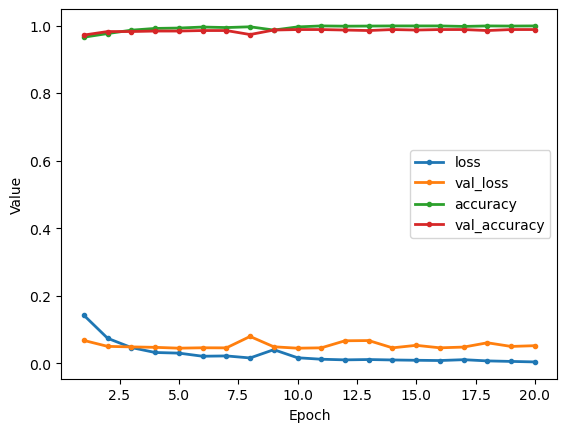

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3955,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131,0.000000,0.0,0.002404,0.002404,0.0,0.000000,0.0,0.000000,0.002404,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3645,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4162,0.003086,0.0,0.000000,0.000000,0.0,0.009259,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,0.007937,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.002646,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3377, 8673)
X_test: (845, 8673)
y_train: (3377,)
y_test: (845,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,220,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,809 (8.64 MB)

 Trainable params: 2,263,809 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 27s 657ms/step - accuracy: 0.6406 - loss: 0.6931

 8/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5263 - loss: 0.6927   

15/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5289 - loss: 0.6905

23/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5556 - loss: 0.6857

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5909 - loss: 0.6777

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6246 - loss: 0.6644

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6432 - loss: 0.6540 - val_accuracy: 0.9941 - val_loss: 0.2277


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.2198

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.1811 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.1555

25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9950 - loss: 0.1355

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.1205

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9946 - loss: 0.1103

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9946 - loss: 0.1071 - val_accuracy: 0.9941 - val_loss: 0.0439


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0018

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0105 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9970 - loss: 0.0119

25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9969 - loss: 0.0121

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0126

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0127

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.0127 - val_accuracy: 0.9882 - val_loss: 0.0543


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0010

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0042 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0070

24/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9970 - loss: 0.0077

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0076

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9974 - loss: 0.0073

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9975 - loss: 0.0071 - val_accuracy: 0.9926 - val_loss: 0.0462


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0011

 8/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 

16/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

24/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0013

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9882 - val_loss: 0.0551


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8335e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0365e-04 

16/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5103e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2187e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2220e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2625e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2509e-04 - val_accuracy: 0.9926 - val_loss: 0.0496


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.5146e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6625e-04 

16/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3561e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3030e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5106e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5234e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4762e-04 - val_accuracy: 0.9926 - val_loss: 0.0512


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5414e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7093e-04 

15/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0247e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1591e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5456e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8406e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9436e-04 - val_accuracy: 0.9896 - val_loss: 0.0593


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.2932e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2843e-04 

15/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5738e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6905e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8177e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9109e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9729e-04 - val_accuracy: 0.9941 - val_loss: 0.0520


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.8823e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2584e-04 

17/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6050e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2737e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1210e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0414e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9979e-04 - val_accuracy: 0.9926 - val_loss: 0.0532


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.7644e-05

 9/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4816e-04 

16/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4898e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4632e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4572e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4168e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3897e-04 - val_accuracy: 0.9911 - val_loss: 0.0565



[Train Accuracy: 100.00% - Test Accuracy: 99.76%]


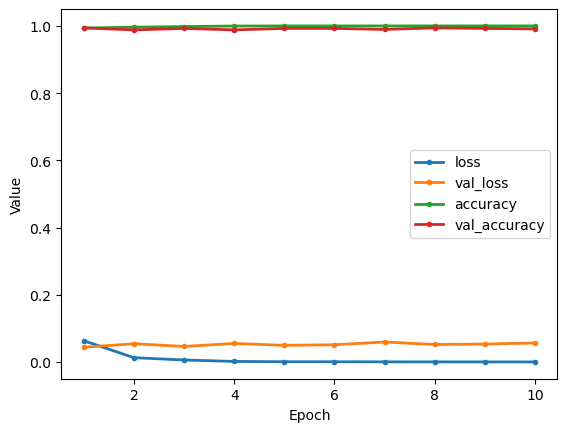

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
3955,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1131,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3645,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4162,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1262,0.002653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,267,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,309,057 (134.69 MB)

 Trainable params: 35,309,057 (134.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 37s 900ms/step - accuracy: 0.3906 - loss: 0.6932

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.4141 - loss: 0.6932 

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.4358 - loss: 0.6931

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.4460 - loss: 0.6931

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.4555 - loss: 0.6931

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4664 - loss: 0.6930

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4773 - loss: 0.6930

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4882 - loss: 0.6929

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4985 - loss: 0.6928

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5088 - loss: 0.6928

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5195 - loss: 0.6927

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5293 - loss: 0.6926

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5384 - loss: 0.6925

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5463 - loss: 0.6923

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5533 - loss: 0.6922

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5606 - loss: 0.6921

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5682 - loss: 0.6919

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5758 - loss: 0.6917

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5833 - loss: 0.6915

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.5906 - loss: 0.6913

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5976 - loss: 0.6911

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6045 - loss: 0.6908

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6111 - loss: 0.6905

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6176 - loss: 0.6902

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6238 - loss: 0.6899

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6299 - loss: 0.6896

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.6358 - loss: 0.6892

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6415 - loss: 0.6888

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6470 - loss: 0.6884

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6524 - loss: 0.6879

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6576 - loss: 0.6874

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6626 - loss: 0.6868

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6675 - loss: 0.6862

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6722 - loss: 0.6856

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6768 - loss: 0.6849

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6813 - loss: 0.6842

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6857 - loss: 0.6834

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6899 - loss: 0.6826

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6940 - loss: 0.6817

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6980 - loss: 0.6808

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7018 - loss: 0.6798

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7056 - loss: 0.6787

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7092 - loss: 0.6777

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.7126 - loss: 0.6767 - val_accuracy: 0.9911 - val_loss: 0.4006


Epoch 2/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.9688 - loss: 0.4030

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9766 - loss: 0.3945 

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9809 - loss: 0.3880

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9837 - loss: 0.3826

 5/43 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9851 - loss: 0.3769

 6/43 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9859 - loss: 0.3711

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9863 - loss: 0.3657

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9868 - loss: 0.3603

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9873 - loss: 0.3548

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9875 - loss: 0.3496

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9877 - loss: 0.3444

12/43 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9880 - loss: 0.3393

13/43 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9881 - loss: 0.3341

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9883 - loss: 0.3292

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9884 - loss: 0.3242

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9886 - loss: 0.3192

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9887 - loss: 0.3142

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9887 - loss: 0.3095

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9887 - loss: 0.3048

20/43 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9887 - loss: 0.3002

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9887 - loss: 0.2958

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9887 - loss: 0.2914

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9888 - loss: 0.2872

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9888 - loss: 0.2832

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9888 - loss: 0.2792

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9888 - loss: 0.2753

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9888 - loss: 0.2716

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9888 - loss: 0.2679

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9889 - loss: 0.2642

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9889 - loss: 0.2607

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9890 - loss: 0.2573

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9890 - loss: 0.2540

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9890 - loss: 0.2507

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9891 - loss: 0.2476

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9891 - loss: 0.2445

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9892 - loss: 0.2415

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9892 - loss: 0.2385

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9893 - loss: 0.2357

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9893 - loss: 0.2329

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9894 - loss: 0.2302

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9894 - loss: 0.2275

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9895 - loss: 0.2249

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9896 - loss: 0.2224

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9896 - loss: 0.2201 - val_accuracy: 0.9956 - val_loss: 0.0282


Epoch 3/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 1.0000 - loss: 0.0054

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0056

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0056

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0055

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0054

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0053

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0052

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0053

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0054

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0054

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0055

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0054

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 0.0055

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0055

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0054

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0054

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0056

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9999 - loss: 0.0058

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9999 - loss: 0.0060

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9999 - loss: 0.0062

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9999 - loss: 0.0063

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9999 - loss: 0.0064

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9998 - loss: 0.0065

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9998 - loss: 0.0066

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9998 - loss: 0.0066

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9998 - loss: 0.0067

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9998 - loss: 0.0068

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0069

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0069

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9997 - loss: 0.0069

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9997 - loss: 0.0070

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9997 - loss: 0.0070

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9997 - loss: 0.0070

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0071

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0071

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0071

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0071

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9996 - loss: 0.0071

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9996 - loss: 0.0071 - val_accuracy: 0.9956 - val_loss: 0.0248


Epoch 4/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 1.0000 - loss: 0.0027

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 0.0024

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0022

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0022

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0021

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0021

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0020

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0020

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0020

10/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0019

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0019

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0019

18/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0019

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0020

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9999 - loss: 0.0021

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9999 - loss: 0.0022

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 0.0023

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 0.0024

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 0.0024

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 0.0025

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9999 - loss: 0.0025

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9998 - loss: 0.0026

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9998 - loss: 0.0026

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9998 - loss: 0.0026

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0027

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0027

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0027

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9998 - loss: 0.0028

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9998 - loss: 0.0028

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9998 - loss: 0.0028

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9998 - loss: 0.0028

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9998 - loss: 0.0028

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9998 - loss: 0.0028

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9941 - val_loss: 0.0276


Epoch 5/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.6154e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 7.8528e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 8.7900e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0010    

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0011

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0011

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0011

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0011

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0011

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0011

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0012

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0012

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0012

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0012

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0013

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0013

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0013

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0013

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0013

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0013

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0013

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0015

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0015

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9999 - loss: 0.0015

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9999 - loss: 0.0016

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9926 - val_loss: 0.0387


Epoch 6/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 7.2777e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.1715e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.5256e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.8221e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 8.0744e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 8.4380e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 8.6447e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 8.7854e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 8.9105e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 9.4870e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 9.9362e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0010    

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0011

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0011

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0011

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0011

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0011

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0011

19/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0011

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0011

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0011

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0011

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0011

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0011

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 0.0011

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0011

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0011

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0011

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0010

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0010

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0010

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0010

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0010

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0010

35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0010

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0010

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0010

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0010

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0010

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0010

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0010

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 9.9626e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 9.9259e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.8909e-04 - val_accuracy: 0.9956 - val_loss: 0.0265


Epoch 7/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.8617e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.1879e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.4281e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7070e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.8215e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.8886e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.9709e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.0196e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.0379e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.0594e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.0689e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.0651e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0599e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0464e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0346e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0289e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.0263e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.0207e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.0151e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0256e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0473e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0619e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0737e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0823e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0893e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0929e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0984e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1050e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1106e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1182e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1248e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1284e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1304e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1317e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.1310e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1289e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1263e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1221e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1169e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1113e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1082e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.1044e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.1005e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.0968e-04 - val_accuracy: 0.9956 - val_loss: 0.0295


Epoch 8/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.3907e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.6726e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.6952e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.6612e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5993e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5614e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5429e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.5375e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5277e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.5376e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5423e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.5373e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.5948e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.6370e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.6730e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.7028e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.7269e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.7456e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.7935e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.8395e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.8797e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9131e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9413e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9641e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9827e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9976e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0156e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0315e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0453e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0619e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0759e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0882e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.0983e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.1064e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.1133e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1189e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1234e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1270e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1304e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1349e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1380e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.1399e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.1415e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.1431e-04 - val_accuracy: 0.9956 - val_loss: 0.0294


Epoch 9/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 1.7406e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.7302e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7696e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7988e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.7960e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8090e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8118e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8231e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8317e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8524e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8667e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.8761e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8829e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8938e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9025e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9065e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9085e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9081e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.9052e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.9012e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8965e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8906e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8830e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8754e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8678e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8627e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8619e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8607e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8601e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8595e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8585e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.8570e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8569e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8571e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8572e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8580e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8622e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8656e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8684e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8706e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8729e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8754e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8775e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.8795e-04 - val_accuracy: 0.9941 - val_loss: 0.0325


Epoch 10/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.2279e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.1527e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.0944e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3166e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8416e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.1399e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.2764e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.3528e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3751e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3698e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3489e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3164e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.2844e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.2480e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.2195e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.1872e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.1533e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.1206e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.0934e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0653e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0366e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.0087e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.9802e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.9572e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.9368e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.9171e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.8967e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.8772e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.8576e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.8392e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.8204e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.8019e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7837e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7650e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7480e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.7309e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.7157e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.7009e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6862e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6713e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6566e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6417e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6272e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.6135e-04 - val_accuracy: 0.9956 - val_loss: 0.0313


Epoch 11/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 1.0000 - loss: 1.1011e-04

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.0405e-04

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0537e-04

 4/43 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.0885e-04

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.1043e-04

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.1169e-04

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.1806e-04

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.2129e-04

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.2424e-04

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.2605e-04

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.2696e-04

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2728e-04

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2753e-04

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2739e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2695e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.2640e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2579e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2551e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.2510e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2461e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.2403e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2340e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2274e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2227e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2184e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2145e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.2106e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.2067e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.2026e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1984e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1942e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1903e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1867e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1835e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.1803e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1770e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1743e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1714e-04

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1683e-04

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1651e-04

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1618e-04

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1584e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.1550e-04

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1518e-04 - val_accuracy: 0.9956 - val_loss: 0.0330


Epoch 12/100


 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 6.1870e-05

 2/43 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 8.1590e-05

 3/43 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.5572e-05

 4/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.8920e-05

 5/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.9684e-05

 6/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.8709e-05

 7/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.7665e-05

 8/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.5935e-05

 9/43 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 9.4431e-05

10/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.5353e-05

11/43 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.7173e-05

12/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 9.8659e-05

13/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 9.9509e-05

14/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0064e-04

15/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0153e-04

16/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0206e-04

17/43 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0236e-04

18/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.0241e-04

19/43 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.0240e-04

20/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0243e-04

21/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0237e-04

22/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0243e-04

23/43 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.0240e-04

24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0236e-04

25/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0231e-04

26/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0225e-04

27/43 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0215e-04

28/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0201e-04

29/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0179e-04

30/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0162e-04

31/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0142e-04

32/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0121e-04

33/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0098e-04

34/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0074e-04

35/43 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.0051e-04

36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.0027e-04

37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.0001e-04

38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.9727e-05

39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.9440e-05

40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.9211e-05

41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.8957e-05

42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.8684e-05

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 9.8426e-05

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 9.8180e-05 - val_accuracy: 0.9956 - val_loss: 0.0330



[Train Accuracy: 100.00% - Test Accuracy: 99.53%]


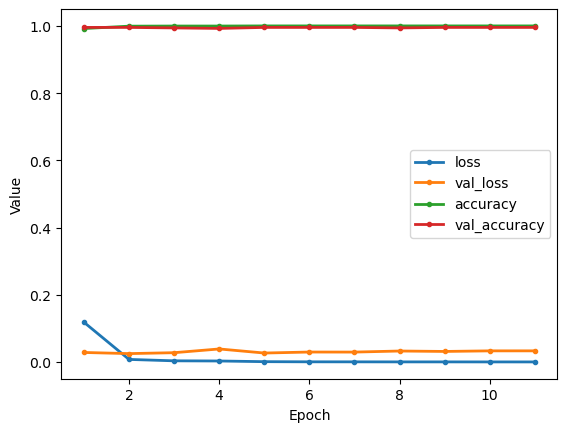

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

 5/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

 5/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/CO-like/report_KA4SC84F.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################